**Install Dependencies**

In [1]:
# %%capture
# !pip install -U fastai diffusers transformers jupyter huggingface-hub gradio;

**Check diffusers version**

In [2]:
import diffusers
diffusers.__version__

'0.6.0'

**Import dependencies**

In [3]:
from pathlib import Path
import hashlib
import json

import logging
logging.disable(logging.WARNING)

from PIL import Image, ImageOps
import numpy as np
import torch
from torchvision import transforms as tfms

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

from tqdm.auto import tqdm

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [4]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Verify cached token**

In [5]:
!ls ~/.huggingface

token


**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML OpenRail-M license](https://huggingface.co/spaces/CompVis/stable-diffusion-license). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v1-4 Model Card**](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [**Stable Diffusion v1-5 Model Card**](https://huggingface.co/runwayml/stable-diffusion-v1-5)

**Select a model**

In [6]:
# model_name = "CompVis/stable-diffusion-v1-4"
model_name = "runwayml/stable-diffusion-v1-5"

**Load autoencoder**

In [7]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", torch_dtype=torch.float16).to("cuda")

# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")

**Load unet**

In [8]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", torch_dtype=torch.float16).to("cuda")

**Select a CLIP model**

In [9]:
clip_name = "openai/clip-vit-large-patch14"

**Load tokenizer**

In [10]:
tokenizer = CLIPTokenizer.from_pretrained(clip_name, torch_dtype=torch.float16)

**Load text encoder**

In [11]:
text_encoder = CLIPTextModel.from_pretrained(clip_name, torch_dtype=torch.float16).to("cuda")

**Define noise scheduler**

In [12]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, 
                                 beta_end=0.012, 
                                 beta_schedule="scaled_linear", 
                                 num_train_timesteps=1000)

**Define method to tokenizer and encode text**

In [13]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

**Define method to encode image as latents**

In [14]:
def pil_to_latent(image):
    # Single image -> single latent in a batch
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(image).unsqueeze(0).to('cuda').half()*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

**Define method to prepare image mask**

In [15]:
def preprocess_mask(mask, latent_dims):
    # Convert mask image to 1-channel black and white
    mask = mask.convert("L")
    # Downscale to latent dimensions
    mask = mask.resize(latent_dims[2:], resample=Image.Resampling.NEAREST)
    # Scale pixel values from [0,255] to [0,1] 
    mask = np.array(mask).astype(np.float32) / 255.0
    # Expand to four channels to match latents
    mask = np.tile(mask, (latent_dims[1], 1, 1))
    # Batch mask image
    mask = mask[None].transpose(0, 1, 2, 3)
    # Convert numpy array to torch tensor
    return torch.from_numpy(mask)

**Define method to convert output tensor to image**

In [16]:
def tensor_to_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

**Define method to save image with unique file name**

In [17]:
def save_img(image, save_dir, fmt='PNG'):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    image.save(f"{save_dir}/{img_hash}.{fmt.lower()}", format=fmt)
    return img_hash

**Define method to pipeline config used to generate an image**

In [18]:
def save_pipe_config(img_name, pipe_config, save_dir):
    with open(f"{save_dir}/{img_name}.json", "w") as write_file:
        json.dump(pipe_config, write_file)

**Define method to perform inpainting**

In [19]:
def generate_inpainting(init_image, mask, prompt, negative_prompt="", strength=0.5, g=0.15, steps=70, generator=None):

    # Encode text prompt
    text = text_enc(prompt)
    # Encode negative prompt
    uncond = text_enc(negative_prompt, text.shape[1])
    # Concatenate encoded prompts
    emb = torch.cat([uncond, text])
    
    # Encode source image to latents
    encoded = pil_to_latent(init_image).to("cuda").half()
    # Initialize latent noise
    noise = torch.randn(encoded.shape, generator=generator, device='cuda', dtype=emb.dtype)
    
    # Create a copy of the encoded image
    latents = encoded.clone()
    
    # Prepare image mask
    mask = preprocess_mask(mask, tuple(encoded.shape)).to('cuda').half()
    
    # Calculate the initial scheduler timestep    
    init_timestep = steps - int(max(min(steps*strength, steps), 0))   
    
    # Set number of time steps for diffusion process
    scheduler.set_timesteps(steps)
    # Add scaled noise to latents
    latents += noise * scheduler.sigmas[init_timestep].to('cuda')
        
    for i,ts in enumerate(tqdm(scheduler.timesteps[init_timestep:])):
        
        # Scale latents
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        # Get model output
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        
        # Rescale guidance
        # https://forums.fast.ai/t/lesson-10-official-topic/101171/101
        pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
        pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
        
        # Update latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Masking
        init_latents = encoded + noise * scheduler.sigmas[init_timestep+i].to('cuda')
        latents = (init_latents * mask) + (latents * (1 - mask))
        
        # Releases all unoccupied cached memory
        torch.cuda.empty_cache()
        
    # Decode output tensor
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

**Download sample image**

In [20]:
# !curl --output cat.jpg "https://images.pexels.com/photos/617278/pexels-photo-617278.jpeg?cs=srgb&dl=pexels-kelvin-valerio-617278.jpg&fm=jpg&w=776&h=512"

**Open sample image**

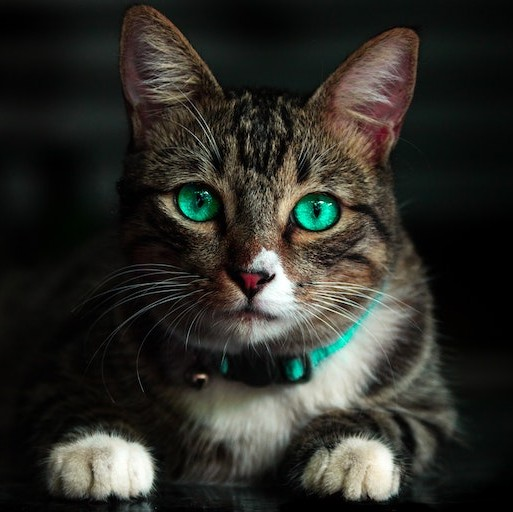

In [21]:
image_path = 'cat_crop.jpg'
src_image = Image.open(image_path).convert('RGB')
src_image

**Import Gradio**

In [22]:
import gradio as gr

**Define method to save image mask from Gradio**

In [23]:
def get_mask(inp):
    mask = Image.fromarray(inp['mask'].astype(np.uint8))
    mask.save('mask.png', format='PNG')
    return mask

**Define Gradio interface to draw image mask**

In [24]:
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=3, min_width=600):
            inp_img = gr.Image(image_path, tool='sketch')
            btn = gr.Button("Save").style(full_width=True)
            out_img = gr.Image()
        
        btn.click(get_mask, inputs=inp_img, outputs=out_img)
        
demo.launch();

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


**Download sample image mask**

In [25]:
# !curl --output mask.png ""

**Open image mask**

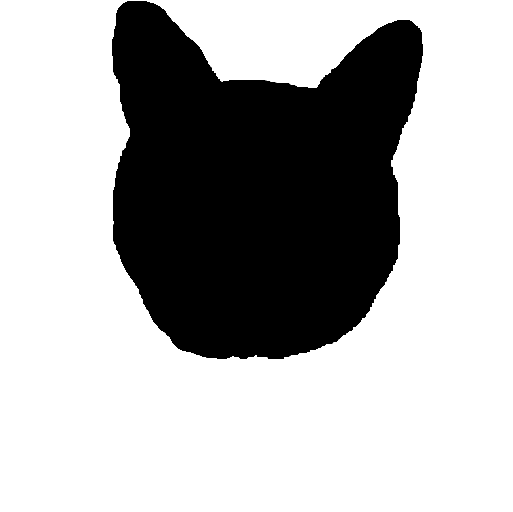

In [26]:
mask_path = 'mask.png'
mask = Image.open(mask_path).convert('RGB')
mask = ImageOps.invert(mask)
mask = ImageOps.fit(mask, src_image.size)
mask

**Define text prompt**

In [27]:
# prompt = "A professional digital painting of a cat, gorgeous digital painting, warm colors, captivating, trending in artstation"
# prompt

In [28]:
prompt = "Tiny cute 3D felt fiber cat, made from Felt fibers, a 3D render, trending on cgsociety, rendered in maya, rendered in cinema4d, made of yarn, square image"
prompt

'Tiny cute 3D felt fiber cat, made from Felt fibers, a 3D render, trending on cgsociety, rendered in maya, rendered in cinema4d, made of yarn, square image'

**Define negative prompt**

In [29]:
negative_prompt = "lowres, bad, error, blurry, compressed, incomplete"
negative_prompt

'lowres, bad, error, blurry, compressed, incomplete'

**Initialize random number generator for consistent images**

In [30]:
generator = torch.Generator(device='cuda')
generator.manual_seed(100);
# generator.manual_seed(789890158);
# generator.manual_seed(1);

**Define pipe config**

In [31]:
pipe_config = {}
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['negative_prompt'] = negative_prompt
pipe_config['init_img'] = str(image_path)
pipe_config['img_mask'] = str(mask_path)
pipe_config['strength'] = 0.7
pipe_config['steps'] = 100
pipe_config['guidance'] = 0.3
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]
pd.DataFrame.from_dict(pipe_config, orient='index')

,0
model,runwayml/stable-diffusion-v1-5
prompt,"Tiny cute 3D felt fiber cat, made from Felt fibers, a 3D render, trending on cgsociety, rendered in maya, rendered in cinema4d, made of yarn, square image"
negative_prompt,"lowres, bad, error, blurry, compressed, incomplete"
init_img,cat_crop.jpg
img_mask,mask.png
strength,0.7
steps,100
guidance,0.3
init_seed,100
generator_state,"[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, ...]"


**Optional: Load a config file to recreate a specific image**

In [32]:
# config_path = Path("../pipe_configs/1313203da0f5566e02a0f32e.json")

In [33]:
# with open(config_path) as f:
#     pipe_config = json.load(f)
#     generator_state = torch.tensor(pipe_config['generator_state'], dtype=torch.uint8)
#     generator.manual_seed(pipe_config['init_seed'])
#     generator.set_state(generator_state)
# pd.DataFrame.from_dict(pipe_config, orient='index')

**Define method that returns a stack of images**

In [34]:
def stack_imgs(imgs):
    w,h = imgs[0].size
    stack = Image.new('RGB', size=(w, len(imgs)*h))
    for i, img in enumerate(imgs): stack.paste(img, box=(0, i*h, w, (i+1)*h))
    return stack

**Define directory to store generated images**

In [35]:
output_dir = Path("./output_dir")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('output_dir')

**Specify number of images to generate**

In [36]:
num_images = 1

**Generate images**

  0%|          | 0/70 [00:00<?, ?it/s]

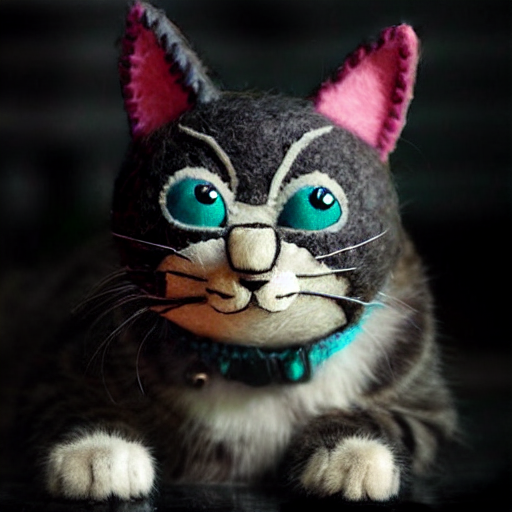

In [37]:
all_images = []
generator_states = []

for i in range(num_images):
    img_tensors = generate_inpainting(init_image=src_image,
                                        mask=mask,
                                        prompt=pipe_config['prompt'], 
                                        negative_prompt=pipe_config['negative_prompt'],
                                        strength=pipe_config['strength'],
                                        g=pipe_config['guidance'], 
                                        steps=pipe_config['steps'], 
                                        generator=generator)
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.extend([tensor_to_img(t) for t in img_tensors])
    torch.cuda.empty_cache()
    
for i, image in enumerate(all_images):
    img_name = save_img(image, save_dir=output_dir)
    save_pipe_config(img_name=img_name, pipe_config=pipe_config, save_dir=output_dir)
    pipe_config['generator_state'] = generator_states[i]

stack_imgs(all_images)